In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.gridspec as gridspec
import seaborn as sns

import geopandas as gpd
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# Overall prescribing

## Import data

In [12]:
q = '''
SELECT
  p.practice,
  pct,
  p.month,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050113',items,0)) AS uti_items,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050103',items,0)) AS tetracyclines,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050108',items,0)) AS sulphonamides_trimethoprim,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0',items,0)) AS coamoxiclav,
  SUM(IF(SUBSTR(p.bnf_code,1,7)='0501021',items,0)) AS cephalosporins,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS quinolones,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050105',items,0)) AS macrolides,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050111',items,0)) AS metroni_tini_ornidazole,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050101',items,0)) AS penicillins,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS all_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6) IN ('050112','050113','050103','050105','050111','050101'),items,0)) AS denom_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050110',items,0)) AS antileprotic,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050109',items,0)) AS antituberculosis,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050107',items,0)) AS some_other_antibacterials,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050104',items,0)) AS aminogylcosides,
  SUM(items) AS items,
  SUM(IF((p.bnf_code like'0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD' 
    OR p.bnf_code='0501015P0%AB' OR p.bnf_code='0501080W0%AE'), p.quantity,0) 
    * r.percent_of_adq) AS numerator_uti_course,
   SUM(IF((p.bnf_code like '0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD'
    OR p.bnf_code like '0501015P0%AB' OR p.bnf_code='0501080W0%AE'), p.items,0)) AS denominator_uti_course,
  ROUND(SUM(actual_cost),2) AS actual_cost,
  AVG(total_list_size) AS list_size,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_item') AS FLOAT64) AS star_pu_items,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_cost') AS FLOAT64) AS star_pu_cost
FROM
  ebmdatalab.alex.antibiotic_prescribing p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND prac.setting = 4
LEFT JOIN
  ebmdatalab.hscic.practice_statistics_all_years stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
LEFT JOIN
  ebmdatalab.hscic.presentation r
ON
  p.bnf_code = r.bnf_code
GROUP BY
  practice,
  pct,
  month
ORDER BY
  practice,
  month
'''

all_antibiotics = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
all_antibiotics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698489 entries, 0 to 698488
Data columns (total 25 columns):
practice                      698489 non-null object
pct                           698489 non-null object
month                         698489 non-null datetime64[ns]
uti_items                     698489 non-null int32
tetracyclines                 698489 non-null int32
sulphonamides_trimethoprim    698489 non-null int32
coamoxiclav                   698489 non-null int32
cephalosporins                698489 non-null int32
quinolones                    698489 non-null int32
macrolides                    698489 non-null int32
metroni_tini_ornidazole       698489 non-null int32
penicillins                   698489 non-null int32
all_broad_spectrum            698489 non-null int32
denom_broad_spectrum          698489 non-null int32
antileprotic                  698489 non-null int32
antituberculosis              698489 non-null int32
some_other_antibacterials     698489 non-null 

In [60]:
pc = all_antibiotics.copy()

pc["percent_broad_spec"] = (pc.all_broad_spectrum/pc.denom_broad_spectrum).fillna(0)
# deal with nulls
pc["three_day_courses"] = (pc.numerator_uti_course/pc.denominator_uti_course).fillna(0)
pc = pc.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course","star_pu_cost","actual_cost"],axis=1)

for column in pc:
    if (pc[column].dtype == np.float64) | (pc[column].dtype == np.int32):
        pc["%s_per_starpu"%column] = pc[column]/pc["star_pu_items"]
    else:
        pc[column] = pc[column]

pc = pc.drop(["star_pu_items_per_starpu","percent_broad_spec_per_starpu","three_day_courses_per_starpu","list_size_per_starpu"],axis=1)
pc.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698489 entries, 0 to 698488
Data columns (total 35 columns):
practice                                 698489 non-null object
pct                                      698489 non-null object
month                                    698489 non-null datetime64[ns]
uti_items                                698489 non-null int32
tetracyclines                            698489 non-null int32
sulphonamides_trimethoprim               698489 non-null int32
coamoxiclav                              698489 non-null int32
cephalosporins                           698489 non-null int32
quinolones                               698489 non-null int32
macrolides                               698489 non-null int32
metroni_tini_ornidazole                  698489 non-null int32
penicillins                              698489 non-null int32
antileprotic                             698489 non-null int32
antituberculosis                         698489 non-null in

### Calculations and percentiles

In [68]:

# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (~pd.isnull(pc.star_pu_items)) & (pc["month"]>"2010-09-01") ]
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
pcf = filtered.groupby('month').quantile(x)
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(20)


,month,percentile,aminogylcosides,aminogylcosides_per_starpu,antileprotic,antileprotic_per_starpu,antituberculosis,antituberculosis_per_starpu,cephalosporins,cephalosporins_per_starpu,...,some_other_antibacterials,some_other_antibacterials_per_starpu,star_pu_items,sulphonamides_trimethoprim,sulphonamides_trimethoprim_per_starpu,tetracyclines,tetracyclines_per_starpu,three_day_courses,uti_items,uti_items_per_starpu
0,2010-10-01,0.10,0.0,0.0,0.0,0.000000,0.0,0.000000,2.0,0.000945,...,0.0,0.000000,1285.021141,8.0,0.004543,7.0,0.003823,0.000000,1.0,0.000611
1,2010-10-01,0.20,0.0,0.0,0.0,0.000000,0.0,0.000000,5.0,0.001730,...,0.0,0.000000,1741.449384,13.0,0.006139,12.0,0.005153,5.142857,3.0,0.001158
2,2010-10-01,0.30,0.0,0.0,0.0,0.000000,0.0,0.000000,7.0,0.002475,...,0.0,0.000000,2227.098062,18.0,0.007332,16.0,0.006263,6.045875,5.0,0.001695
3,2010-10-01,0.40,0.0,0.0,0.0,0.000000,0.0,0.000000,10.0,0.003199,...,0.0,0.000000,2781.836536,24.0,0.008284,22.0,0.007231,6.633333,7.0,0.002217
4,2010-10-01,0.50,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,0.003978,...,0.0,0.000000,3393.865396,31.0,0.009155,28.0,0.008276,7.000000,9.0,0.002746
5,2010-10-01,0.60,0.0,0.0,0.0,0.000000,0.0,0.000000,18.0,0.004929,...,0.0,0.000000,4050.610752,37.0,0.010040,35.0,0.009293,7.000000,12.0,0.003344
6,2010-10-01,0.70,0.0,0.0,0.0,0.000000,0.0,0.000000,23.0,0.006144,...,1.0,0.000175,4799.792600,47.0,0.010960,43.0,0.010572,7.351724,16.0,0.003982
7,2010-10-01,0.80,0.0,0.0,0.0,0.000000,1.0,0.000214,31.0,0.007748,...,1.0,0.000300,5735.567645,57.0,0.012084,55.0,0.012223,7.776316,21.0,0.004818
8,2010-10-01,0.90,0.0,0.0,1.0,0.000264,2.0,0.000517,45.0,0.010852,...,2.0,0.000505,7006.119633,74.0,0.013820,73.0,0.014927,9.000000,30.0,0.006223
9,2010-10-01,0.01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,743.201644,2.0,0.001234,1.0,0.001103,0.000000,0.0,0.000000


## Practice level plots

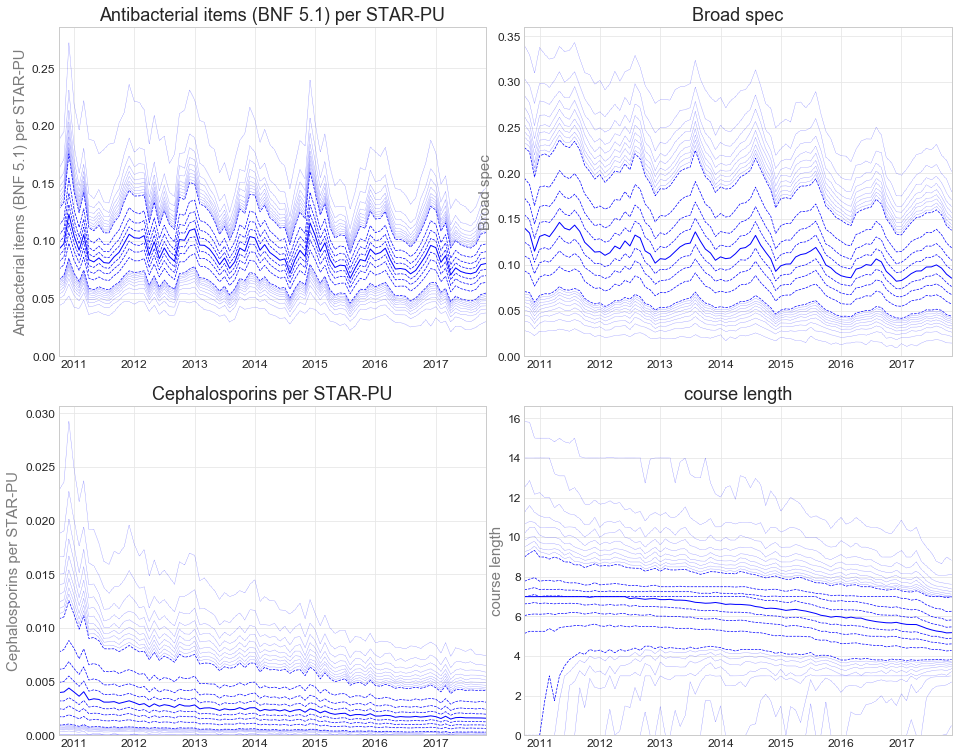

In [67]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'Broad spec'),
     (2,'cephalosporins_per_starpu',1,0,'Cephalosporins per STAR-PU'),
     (3,'three_day_courses',1,1, 'course length')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=1)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.4)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=0.7)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.09,hspace = 0.15)
plt.savefig('practice_deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


## CCG level

In [13]:
all_antibiotics_ccg = all_antibiotics.groupby(['pct','month'],as_index=False).sum()
pc_ccg = all_antibiotics_ccg
pc_ccg['Items per STAR-PU'] = pc_ccg['items'] / pc_ccg.star_pu_items
pc_ccg['Cost per STAR-PU'] = pc_ccg.actual_cost / pc_ccg.star_pu_cost
x = np.arange(0.1, 1, 0.1)
pc_ccg = pc_ccg.groupby('month').quantile(x)
pc_ccg = pc_ccg.reset_index().rename(columns={"level_1": 'percentile'})
pc_ccg.head(9)

C:\Users\Alex\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,month,percentile,Cost per STAR-PU,Items per STAR-PU,actual_cost,items,list_size,star_pu_cost,star_pu_items
0,2010-08-01,0.1,inf,inf,1509.582,330.8,0.0,0.0,0.0
1,2010-08-01,0.2,inf,inf,26101.196,5825.0,0.0,0.0,0.0
2,2010-08-01,0.3,inf,inf,33492.082,7210.8,0.0,0.0,0.0
3,2010-08-01,0.4,inf,inf,39588.422,8239.4,0.0,0.0,0.0
4,2010-08-01,0.5,NaN,NaN,45496.770,9222.0,0.0,0.0,0.0
5,2010-08-01,0.6,inf,inf,50291.948,10472.2,0.0,0.0,0.0
6,2010-08-01,0.7,inf,inf,58276.420,11783.2,0.0,0.0,0.0
7,2010-08-01,0.8,inf,inf,66578.656,13897.4,0.0,0.0,0.0
8,2010-08-01,0.9,inf,inf,84900.716,17775.6,0.0,0.0,0.0


In [14]:
dfp = pc_ccg.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'Items per STAR-PU',0,0), (1,'Cost per STAR-PU',0,1)]


fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=0.7)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=0.4)
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Antibacterial items/cost (BNF 5.1) per STAR-PU', size =15, alpha=0.6)
    ax.set_title(i[1],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.09,hspace = 0.15)
plt.savefig('ccg_deciles.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

ValueError: Axis limits cannot be NaN or Inf

# MAPS

In [15]:
#aggregate over last year
ccg_last_year = all_antibiotics_ccg.loc[all_antibiotics_ccg.month >='2016-11-01']
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year['Items per STAR-PU'] = ccg_last_year['items'] / ccg_last_year.star_pu_items
ccg_last_year['Cost per STAR-PU'] = ccg_last_year.actual_cost / ccg_last_year.star_pu_cost
ccg_last_year.head()

,items,actual_cost,list_size,star_pu_items,star_pu_cost,Items per STAR-PU,Cost per STAR-PU
pct,,,,,,,
00C,75560,363359.15,1510097.0,8.069967e+05,3.302717e+06,0.093631,0.110018
00D,234322,1137844.36,4071768.0,2.193138e+06,8.983378e+06,0.106843,0.126661
00J,191848,989371.63,3590662.0,1.910417e+06,7.847540e+06,0.100422,0.126074
00K,225624,1129830.23,4141161.0,2.182076e+06,8.956308e+06,0.103399,0.126149
00L,255345,1179988.45,4496539.0,2.503709e+06,1.023431e+07,0.101987,0.115297


In [16]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = pd.read_csv('ccg_for_map.csv')
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

,pct,items,actual_cost,list_size,star_pu_items,star_pu_cost,Items per STAR-PU,Cost per STAR-PU,code
name,,,,,,,,,
NHS DARLINGTON CCG,00C,75560,363359.15,1510097.0,8.069967e+05,3.302717e+06,0.093631,0.110018,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,234322,1137844.36,4071768.0,2.193138e+06,8.983378e+06,0.106843,0.126661,00D
NHS NORTH DURHAM CCG,00J,191848,989371.63,3590662.0,1.910417e+06,7.847540e+06,0.100422,0.126074,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,225624,1129830.23,4141161.0,2.182076e+06,8.956308e+06,0.103399,0.126149,00K
NHS NORTHUMBERLAND CCG,00L,255345,1179988.45,4496539.0,2.503709e+06,1.023431e+07,0.101987,0.115297,00L


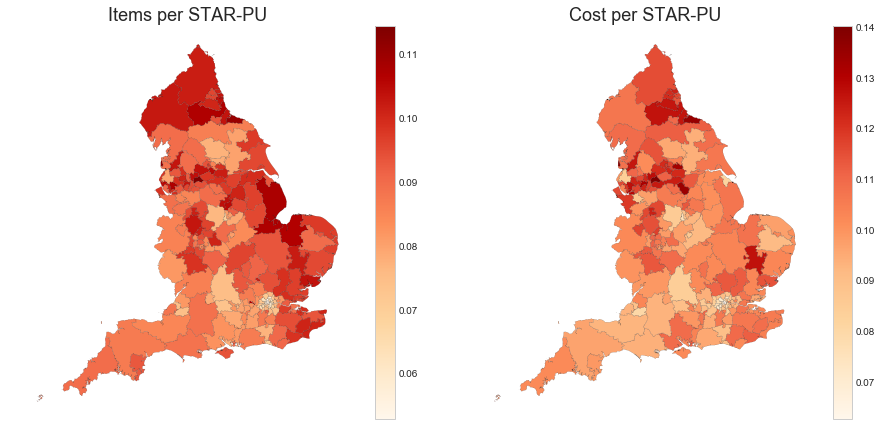

In [18]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'Items per STAR-PU',0,0),      (1,'Cost per STAR-PU',0,1)]#, 
     #(2,'Percent high dose (by OME)',1,0),     (3,'Total cost (per 1000)',1,1)]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[1],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()